<a href="https://colab.research.google.com/github/Alton01/food_classification_with_pytorch/blob/main/04_food_classification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
from torch import nn

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
device

'cpu'

In [7]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# if the image folder doesn't exist, download it and prepare it

if image_path.is_dir():
  print(f"{image_path} directory already exists....... skipping download")
else:
  print(f"{image_path} doesn't exists....... creating one")
  image_path.mkdir(parents=True, exist_ok=True)


  # Download Pizza, Steak and Sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading Pizza, Steak and Sushi data")
  f.write(request.content)

  # unzip pizza, steak, sushi data. Extract images and  send to image path
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping Pizza, Steak and Sushi data")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists....... skipping download
Unzipping Pizza, Steak and Sushi data


In [ ]:
data_path / "pizza_steak_sushi.zip"

PosixPath('data/pizza_steak_sushi.zip')

In [8]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [9]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.


In [10]:
# setup test and train paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Randomimage path: data/pizza_steak_sushi/test/sushi/719108.jpg
Image class: sushi
Image height: 512
Image width: 512


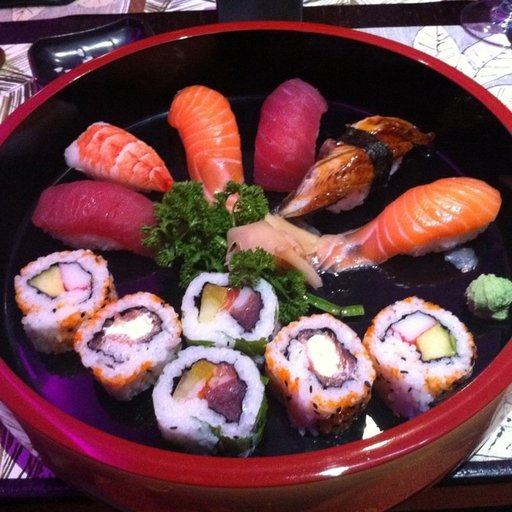

In [15]:
# visualizing a random image through code. PIL - Python Imaging Library

import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg")) # directs to a path for the images

# pick random image path

random_image_path = random.choice(image_path_list)


image_class = random_image_path.parent.stem

#open image

img = Image.open(random_image_path)

print(f"Randomimage path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

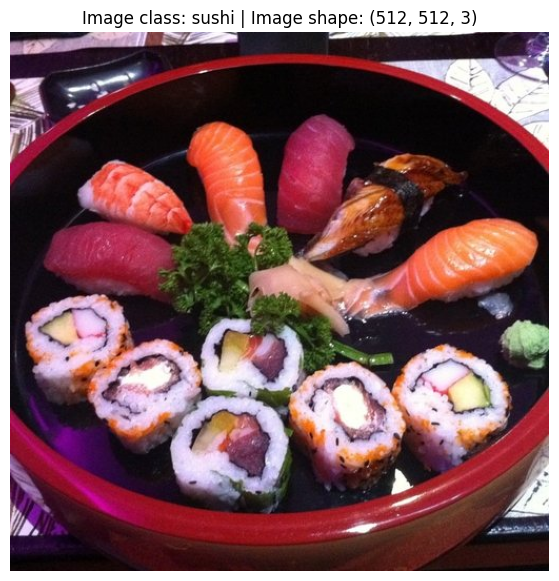

In [16]:
# visualize an image with matplotlib

import numpy as np
import matplotlib.pyplot as plt

#turn the image into an array
img_as_array = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}")
plt.axis(False)

In [ ]:
img_as_array

In [19]:
# transforming images/data into pytorch tensors

import torch
from torch.utils.data import DataLoader

from torchvision import datasets, transforms


In [25]:
# transforms are used to help get images ready to be used with a model/perform data augmentation

data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)), # changes image shape and pixel size
    transforms.RandomHorizontalFlip(p=0.5), #probability
    transforms.ToTensor()
])

In [26]:
data_transform(img).dtype

torch.float32

In [ ]:
# comparing original images to transformed images.
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis("off")

      # transform and plot image
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

In [ ]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # transform for data
                                  target_transform=None) # transform for the target / label

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

In [31]:
class_names = train_data.classes

class_names

['pizza', 'steak', 'sushi']

In [32]:
# Get class names as dict

class_dict = train_data.class_to_idx

class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [33]:
len(train_data), len(test_data)

(225, 75)

In [37]:
img, label = train_data[0][0], train_data[0][1]

print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

In [ ]:
img_permute = img.permute(1, 2, 0)

print(f"Original shape: {img.shape}") # (C, H, W)
print(f"Image permuted shape: {img_permute.shape}") # (H, W, C)

plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

In [40]:
# turn test and train data into DataLoader's batches

from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1, # how many cpu cores used to load our data
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x785098a07d90>,
 <torch.utils.data.dataloader.DataLoader at 0x785098e1ad90>)

In [41]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64])
Label shape: torch.Size([1])


In [42]:
# Loading image data with a custom dataset

import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [43]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [44]:
# creating a helper function to get class names from a directory.

#set up path for target directory

target_directory = train_dir
print(f"Target dir: {target_directory}")

# get class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [50]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  # finds the class folder name in a target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # Raise error if class names could not be found

  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in directory: {directory}.... Please check file structure")

  # create a dictionary of index labels ( computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

In [51]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [52]:
# create a custom dataset to replicate image folder

# write a custom dataset class

from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
  def __init__(self,
               targ_dir: str,
               transform=None):

    # create class attributes
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)


  # create a  function to load images
  def load_image(self, index: int) -> Image.Image:
    # opens an image via a path and returns it.
    image_path = self.paths[index]

    return Image.open(image_path)


  #overwrite __len__
  def __len__(self) -> int:
    # returns total number of samples
    return len(self.paths)


  # overwrite __getitem()__ method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    # loads and returns a sample
    img = self.load_image(index)
    class_name = self.paths[index].parent.name #expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # transformation if necessary (data augmentation)
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)
    else:
      return img, class_idx # return untransformed image and label

In [53]:
# create a transform
from torchvision import transforms

train_transforms = transforms.Compose({
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
})

test_transforms = transforms.Compose({
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
})

In [54]:
# test out ImageFolderCustom

train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                        transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=test_transforms)

In [55]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7850989c4110>,
 <__main__.ImageFolderCustom at 0x785098a01f90>)

In [57]:
len(train_data), len(train_data_custom)

(225, 225)

In [58]:
len(test_data), len(test_data_custom)

(75, 75)

In [60]:
# write a helper function to display random images from our custom datasets

# create a function to take in a dataset

def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

  # adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f" For display purposes, n shouldn't be larger than 10")

  # set seed
  if seed:
    random.seed(seed)

  # get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # setup plot
  plt.figure(figsize=(16,8))

  # loop through the random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]


    # adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0)

    # plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"class: {classes[targ_label]}"

      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"

      plt.title(title)

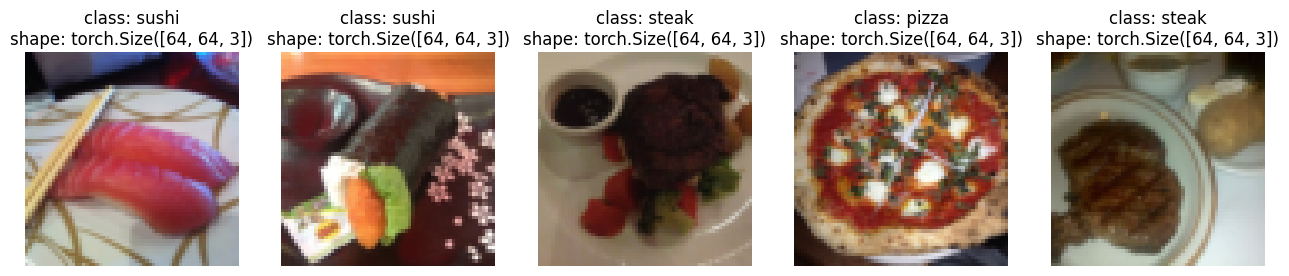

In [62]:
# display random images from the imagefolder created datasets

display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

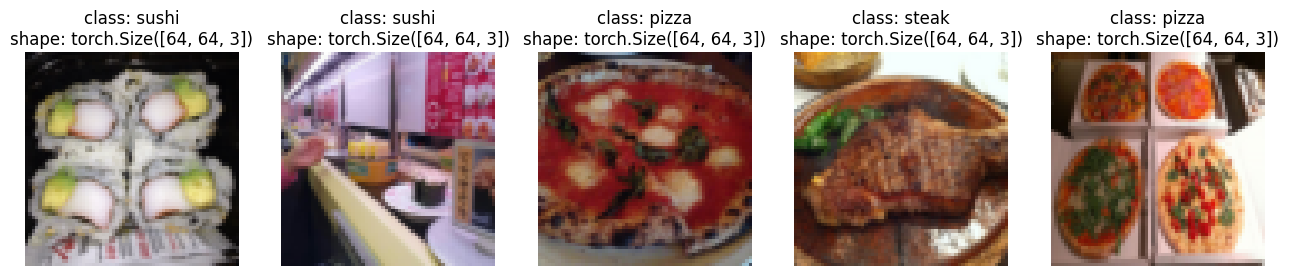

In [65]:
# display random images from the ImageFolderCustom Dataset

display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=None)

In [66]:
# turn custom loaded images/datasets into  dataloader's

from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom =  DataLoader(dataset=test_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=False)

train_dataloader_custom, test_dataloader_custom



(<torch.utils.data.dataloader.DataLoader at 0x7850984ddc50>,
 <torch.utils.data.dataloader.DataLoader at 0x785098a12110>)

In [67]:
# Get image and label from custom data loader

img_custom, label_custom = next(iter(train_dataloader_custom))

print(f"Image shape: {img_custom.shape}")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([32, 3, 64, 64])
Label shape: torch.Size([32])


In [68]:
# Data augmentation is the process of artificially adding diversity to your training data.
# in the case of image data, this may mean applying various image transformations to the training images.
# image data augmentation is looking at the same image from different perspectives. To artificially increase the diversity of a dataset.

from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [69]:
# Get all image paths

image_path_list = list(image_path.glob("*/*/*.jpg"))

image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/502076.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3873283.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/2117351.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/100274.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1285886.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1882831.jpg')]

In [ ]:
#Plot random transformed images

plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform,
                        n=3,
                        seed=None)

In [72]:
# Model 0: TinyVGG Architecture without data augmentation

# create transforms

simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [74]:
# load and transform data

from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform,
                                        )

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# Turn the datasets into DataLoaders

import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create Dataloaders

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

In [ ]:
# Create TinyVGG Model Class.

In [90]:
class TinyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
      super().__init__()
      self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                       stride=2)
      )
      self.conv_block_2 = nn.Sequential(
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                       stride=2)
      )
      self.classifier = nn.Sequential(
          nn.Flatten(),
           # we need to ensure hidden values unit on exiting out channels in  nn.Conv2d matches in_features (hidden_unit) hence the 13 * 13
          nn.Linear(in_features=hidden_units*13*13,
                    out_features=output_shape)
      )

  def forward(self, x):
    # return self.classifier(self.conv_block_2(self.conv_block_1(x))) benefits from operator fusion
    #this enables you avoid transportation between memory and compute
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    # we need to ensure hidden values unit on exiting out channels in  nn.Conv2d matches in_features (hidden_unit) hence the 13 * 13
    x = self.classifier(x)
    # print(x.shape)
    return x


In [91]:
# create model instance

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels in our image data
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)


model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [92]:
# Pass dummy data through model
# Get a single image batch

image_batch, label_batch = next(iter(train_dataloader_simple))

print(f"Image batch shape: {image_batch.shape}")
print(f"Label batch shape: {label_batch.shape}")

Image batch shape: torch.Size([32, 3, 64, 64])
Label batch shape: torch.Size([32])


In [93]:
# Try a forward pass
 # we need to ensure hidden values unit on exiting out channels in  nn.Conv2d matches in_features (hidden_unit) hence the * 13 * 13
model_0(image_batch)

# torch.Size([32, 10, 32, 32])
# torch.Size([32, 10, 13, 13])
# RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1690 and 10x3)

torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])


tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

In [ ]:
# Using the torchinfo package to get a summary of our model
# Torchinfo can be used to get an idea of the shapes going through our model

In [ ]:
#Install torchinfo

try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=(1, 3, 64, 64))